# Analysis of Vertical velocity and LWP, IWP

## Necessary libraries

In [1]:
# Libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import pandas as pd
import array as ar
import matplotlib.patches as mpatches

import metpy
from metpy.units import units #had to install metpy
import wrf #had to install to have wrf-python things for vertical levels
import metpy.calc as mpcalc 

import matplotlib.dates as mdates # formatting heatmaps
import datetime
from matplotlib.ticker import MaxNLocator, FuncFormatter, ScalarFormatter

## Datasets

In [2]:
# define main paths for observations and reanalysis + for simulations
obs_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/'
sim_path = '/media/irene/Elements/wrf_micro/'

In [3]:
# Open datasets:
# ERA5
ds_ERA = xr.open_dataset(f'{obs_path}/ERA5-WTQ-MCScase.nc') #with range lat:25-40, lon:70-115 and days 2008-July 14 to 24

#WRF (regridded to ERA5 horizontal spatial resolution)
ds_wtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_W-16to24.nc')
ds_wmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_W-16to24.nc')
ds_wcam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_W-16to24.nc')
ds_wylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_W-16to24.nc')
ds_wwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_W-16to24.nc')
ds_wwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_W-16to24.nc')


#to compute pressure levels need P and PB of WRF (already regridded to ERA5 lat and lon)
ds_Ptho, ds_PBtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_P-16to24.nc'), xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_PB-16to24.nc')
ds_Pmor, ds_PBmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_P-16to24.nc'), xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_PB-16to24.nc')
ds_Pcam, ds_PBcam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_P-16to24.nc'), xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_PB-16to24.nc')
ds_Pylin, ds_PBylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_P-16to24.nc'), xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_PB-16to24.nc')
ds_Pwdm7, ds_PBwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_P-16to24.nc'), xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_PB-16to24.nc')
ds_Pwdm6, ds_PBwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_P-16to24.nc'), xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_PB-16to24.nc')

## Cut spatial and temporal domain

In [4]:
# Cut time:
start = '2008-07-16T00:00:00.000000000'
end = '2008-07-24T23:00:00.000000000'
ds_ERA = ds_ERA.sel(time=slice(start, end))

#define time:
times=['2008-07-16', '2008-07-17', '2008-07-18', '2008-07-19', '2008-07-20', '2008-07-21', '2008-07-22', '2008-07-23', '2008-07-24']

In [5]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 115

#cut w,theta and q
ds_ERAc = ds_ERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_wthoc = ds_wtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_wmorc = ds_wmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_wcamc = ds_wcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_wylinc = ds_wylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_wwdm7c = ds_wwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_wwdm6c = ds_wwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

#cut variables for vertical levels
ds_Pthoc, ds_PBthoc = ds_Ptho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pmorc, ds_PBmorc = ds_Pmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pcamc, ds_PBcamc = ds_Pcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pylinc, ds_PBylinc = ds_Pylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pwdm7c, ds_PBwdm7c = ds_Pwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_Pwdm6c, ds_PBwdm6c = ds_Pwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2)), ds_PBwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

## Vertical profiles of W

In [6]:
# Convert w of ERA from Pa/s to m/s: compute vertical velocity from omega
l_wERA = metpy.calc.vertical_velocity(ds_ERAc.w, ds_ERAc.level * units.hPa, ds_ERAc.t * units.kelvin, mixing_ratio=ds_ERAc.q)
meanl_wERA =(l_wERA).mean(dim=('latitude', 'longitude', 'time')) 

In [7]:
# Need to interpolate vertical levels of W (50) to 49 cause of P and PB are on those levels
# Choose the target levels (e.g., 49 new levels) 
target_levels = np.arange(49)

# Interpolate W to 49 levels instead of 50 (conversion from staggered to non-staggered levels)
ids_wthoc = ds_wthoc.interp(bottom_top_stag=target_levels, method='linear', kwargs={'fill_value': 'extrapolate'})
ids_wmorc = ds_wmorc.interp(bottom_top_stag=target_levels, method='linear', kwargs={'fill_value': 'extrapolate'})
ids_wcamc = ds_wcamc.interp(bottom_top_stag=target_levels, method='linear', kwargs={'fill_value': 'extrapolate'})
ids_wylinc = ds_wylinc.interp(bottom_top_stag=target_levels, method='linear', kwargs={'fill_value': 'extrapolate'})
ids_wwdm7c = ds_wwdm7c.interp(bottom_top_stag=target_levels, method='linear', kwargs={'fill_value': 'extrapolate'})
ids_wwdm6c = ds_wwdm6c.interp(bottom_top_stag=target_levels, method='linear', kwargs={'fill_value': 'extrapolate'})

In [8]:
# Compute pressure levels of wrf variables (to convert from wrf vertical coordinate system to ERA5 vertical coordinates)
thopr_lev = (ds_Pthoc.P + ds_PBthoc.PB)/100 #/100 is to have it in hPa
morpr_lev = (ds_Pmorc.P + ds_PBmorc.PB)/100 
campr_lev = (ds_Pcamc.P + ds_PBcamc.PB)/100
ylinpr_lev = (ds_Pylinc.P + ds_PBylinc.PB)/100
wdm7pr_lev = (ds_Pwdm7c.P + ds_PBwdm7c.PB)/100
wdm6pr_lev = (ds_Pwdm6c.P + ds_PBwdm6c.PB)/100

In [9]:
# Mean over time to be able to interpolate (cause interpolation is max for 3D variables)
thoprt_lev = thopr_lev.mean(dim=('XTIME'))
morprt_lev = morpr_lev.mean(dim=('XTIME'))
camprt_lev = campr_lev.mean(dim=('XTIME'))
ylinprt_lev = ylinpr_lev.mean(dim=('XTIME'))
wdm7prt_lev = wdm7pr_lev.mean(dim=('XTIME'))
wdm6prt_lev = wdm6pr_lev.mean(dim=('XTIME'))

In [10]:
# Average over time to interpolate vertical levels for graphs
meant_wERA = (ds_ERAc.w).mean('time') #one is enough, no need to do it also for w and q for era

meant_wtho= ids_wthoc.mean('XTIME')
meant_wmor = ids_wmorc.mean('XTIME')
meant_wcam = ids_wcamc.mean('XTIME')
meant_wylin = ids_wylinc.mean('XTIME')
meant_wwdm7 = ids_wwdm7c.mean('XTIME')
meant_wwdm6 = ids_wwdm6c.mean('XTIME')

Note: 
- problem with interpolation cause it needs 3D datasets but our are 4D. So do the mean overtime
- not all levels of ERA5 used cause of min and max of WRF: from 30 to 975 hPa (29 levels)

In [11]:
# 3D interpolation: but problem with time -> mean over time + not all levels because of min and max levels of WRF
ulev=[30,50,70,100,125,150,175,200,225,250,300,350,400,450,500,550,600,650,700,750,775,800,825,850,875,900,925,950,975]

dsi_wthoc = wrf.interplevel(meant_wtho.W, thoprt_lev, ulev[::-1])
dsi_wmorc = wrf.interplevel(meant_wmor.W, morprt_lev, ulev[::-1])
dsi_wcamc = wrf.interplevel(meant_wcam.W, camprt_lev, ulev[::-1])
dsi_wylinc = wrf.interplevel(meant_wylin.W, ylinprt_lev, ulev[::-1])
dsi_wwdm7c = wrf.interplevel(meant_wwdm7.W, wdm7prt_lev, ulev[::-1])
dsi_wwdm6c = wrf.interplevel(meant_wwdm6.W, wdm6prt_lev, ulev[::-1])

# Select levels of ERA5 shared with WRF
imeanl_wERA = meanl_wERA.sel(level=ulev)

In [12]:
# Mean over 2d space for interpolated values to have graphs level vs variable value
imeanl_wtho = dsi_wthoc.mean(dim=('latitude', 'longitude'))
imeanl_wmor = dsi_wmorc.mean(dim=('latitude', 'longitude'))
imeanl_wcam = dsi_wcamc.mean(dim=('latitude', 'longitude'))
imeanl_wylin = dsi_wylinc.mean(dim=('latitude', 'longitude'))
imeanl_wwdm7 = dsi_wwdm7c.mean(dim=('latitude', 'longitude'))
imeanl_wwdm6 = dsi_wwdm6c.mean(dim=('latitude', 'longitude'))

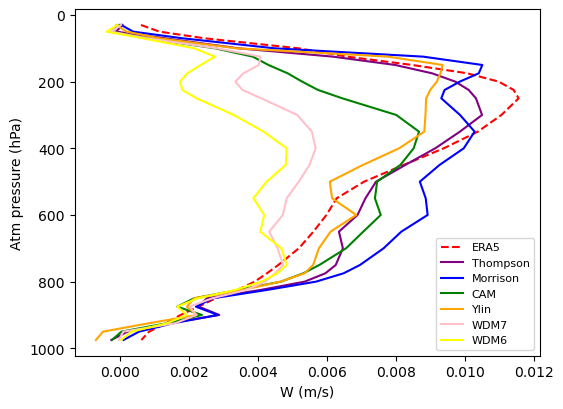

In [13]:
# Graph W
nrows, ncols = 1,1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6,4.5))

#w
axs.plot(imeanl_wERA.values, imeanl_wERA.level, linestyle='dashed', color='r', label='ERA5')
axs.plot(imeanl_wtho, imeanl_wtho.level, color='purple', label='Thompson')
axs.plot(imeanl_wmor, imeanl_wmor.level, color='b', label='Morrison')
axs.plot(imeanl_wcam, imeanl_wcam.level, color='green', label='CAM')
axs.plot(imeanl_wylin, imeanl_wylin.level, color='orange', label='Ylin')
axs.plot(imeanl_wwdm7, imeanl_wwdm7.level, color='pink', label='WDM7')
axs.plot(imeanl_wwdm6, imeanl_wwdm6.level, color='yellow', label='WDM6')

axs.set_xlabel('W (m/s)') 
axs.set_ylabel('Atm pressure (hPa)')
axs.invert_yaxis() #to invert y axis: 1000 hPa is rougly sea level = 0 height
axs.legend(fontsize=8)

## Vertical profile with time only for Sichuan Basin

In [14]:
# To convert w from pa/s (omega) to m/s
l_wERA = metpy.calc.vertical_velocity(ds_ERAc.w, ds_ERAc.level * units.hPa, ds_ERAc.t * units.kelvin, mixing_ratio=0)
# Mean over 2d space to have vertical level and time
means_wERA =(l_wERA).mean(dim=('latitude', 'longitude'))

In [15]:
# Transpose to have time and levels in the right order for graphs
means_wERA = means_wERA.transpose(transpose_coords=True, missing_dims='raise') #to have the right order in time and levels

# Select shared levels of ERA5 and WRF
means_wERA = means_wERA.sel(level=ulev)

In [16]:
# Mean over 2d space of W
means_wtho = (ds_wthoc.W).mean(dim=('latitude', 'longitude'))
means_wmor = (ds_wmorc.W).mean(dim=('latitude', 'longitude'))
means_wcam = (ds_wcamc.W).mean(dim=('latitude', 'longitude'))
means_wylin = (ds_wylinc.W).mean(dim=('latitude', 'longitude'))
means_wwdm7 = (ds_wwdm7c.W).mean(dim=('latitude', 'longitude'))
means_wwdm6 = (ds_wwdm6c.W).mean(dim=('latitude', 'longitude'))

In [17]:
# Transpose to have the time on x axis and levels on y
wtho_st = means_wtho.transpose(transpose_coords=True, missing_dims='raise')
wmor_st = means_wmor.transpose(transpose_coords=True, missing_dims='raise')
wcam_st = means_wcam.transpose(transpose_coords=True, missing_dims='raise')
wylin_st = means_wylin.transpose(transpose_coords=True, missing_dims='raise')
wwdm7_st = means_wwdm7.transpose(transpose_coords=True, missing_dims='raise')
wwdm6_st = means_wwdm6.transpose(transpose_coords=True, missing_dims='raise')

### Heatmaps with interpolated levels of W

In [18]:
# Mean over latitude to be able to interpolate (3d datasets) - this is for levels (don't have to do it again)
thoprla_lev = thopr_lev.mean(dim=('latitude'))
morprla_lev = morpr_lev.mean(dim=('latitude'))
camprla_lev = campr_lev.mean(dim=('latitude'))
ylinprla_lev = ylinpr_lev.mean(dim=('latitude'))
wdm7prla_lev = wdm7pr_lev.mean(dim=('latitude'))
wdm6prla_lev = wdm6pr_lev.mean(dim=('latitude'))

# Transpose to have bottom_top as first to be able to interpolate
thoprla_lev = thoprla_lev.transpose('bottom_top','XTIME','longitude')
morprla_lev = morprla_lev.transpose('bottom_top','XTIME','longitude')
camprla_lev = camprla_lev.transpose('bottom_top','XTIME','longitude')
ylinprla_lev = ylinprla_lev.transpose('bottom_top','XTIME','longitude')
wdm7prla_lev = wdm7prla_lev.transpose('bottom_top','XTIME','longitude')
wdm6prla_lev = wdm6prla_lev.transpose('bottom_top','XTIME','longitude')

In [19]:
# Define shared levels
ulev=[30,50,70,100,125,150,175,200,225,250,300,350,400,450,500,550,600,650,700,750,775,800,825,850,875,900,925,950,975]

# W mean over latitude for variable and levels to have 3d data to interpolate
meanla_wtho = (ids_wthoc.W).mean(dim=('latitude'))
meanla_wmor = (ids_wmorc.W).mean(dim=('latitude'))
meanla_wcam = (ids_wcamc.W).mean(dim=('latitude'))
meanla_wylin = (ids_wylinc.W).mean(dim=('latitude'))
meanla_wwdm7 = (ids_wwdm7c.W).mean(dim=('latitude'))
meanla_wwdm6 = (ids_wwdm6c.W).mean(dim=('latitude'))

# Change the order of dimensions to interpolate on levels (bottom_top_stag has to be first)
meanla_wtho = meanla_wtho.transpose('bottom_top_stag','XTIME','longitude')
meanla_wmor = meanla_wmor.transpose('bottom_top_stag','XTIME','longitude')
meanla_wcam = meanla_wcam.transpose('bottom_top_stag','XTIME','longitude')
meanla_wylin = meanla_wylin.transpose('bottom_top_stag','XTIME','longitude')
meanla_wwdm7 = meanla_wwdm7.transpose('bottom_top_stag','XTIME','longitude')
meanla_wwdm6 = meanla_wwdm6.transpose('bottom_top_stag','XTIME','longitude')

# Interpolate 3d data
dsii_wthoc = wrf.interplevel(meanla_wtho, thoprla_lev, ulev)
dsii_wmorc = wrf.interplevel(meanla_wmor, morprla_lev, ulev)
dsii_wcamc = wrf.interplevel(meanla_wcam, camprla_lev, ulev)
dsii_wylinc = wrf.interplevel(meanla_wylin, ylinprla_lev, ulev)
dsii_wwdm7c = wrf.interplevel(meanla_wwdm7, wdm7prla_lev, ulev)
dsii_wwdm6c = wrf.interplevel(meanla_wwdm6, wdm6prla_lev, ulev)

In [20]:
# 3D interpolation to fix W heatmaps
ulev=[30,50,70,100,125,150,175,200,225,250,300,350,400,450,500,550,600,650,700,750,775,800,825,850,875,900,925,950,975]

iimeanl_wtho = np.zeros([216,29])
iimeanl_wmor = np.zeros([216,29])
iimeanl_wcam = np.zeros([216,29])
iimeanl_wylin = np.zeros([216,29])
iimeanl_wwdm7 = np.zeros([216,29])
iimeanl_wwdm6 = np.zeros([216,29])

for t in range(216):
    dsi_wthoc = wrf.interplevel(ids_wthoc.W.values[t], thoprt_lev, ulev)
    iimeanl_wtho[t] = np.nanmean(dsi_wthoc,axis=(1,2))

    dsi_wmorc = wrf.interplevel(ids_wmorc.W.values[t], morprt_lev, ulev)
    iimeanl_wmor[t] = np.nanmean(dsi_wmorc,axis=(1,2))
    
    dsi_wcamc = wrf.interplevel(ids_wcamc.W.values[t], camprt_lev, ulev)
    iimeanl_wcam[t] = np.nanmean(dsi_wcamc,axis=(1,2))

    dsi_wylinc = wrf.interplevel(ids_wylinc.W.values[t], ylinprt_lev, ulev)
    iimeanl_wylin[t] = np.nanmean(dsi_wylinc,axis=(1,2))

    dsi_wwdm7c = wrf.interplevel(ids_wwdm7c.W.values[t], wdm7prt_lev, ulev)
    iimeanl_wwdm7[t] = np.nanmean(dsi_wwdm7c,axis=(1,2))

    dsi_wwdm6c = wrf.interplevel(ids_wwdm6c.W.values[t], wdm6prt_lev, ulev)
    iimeanl_wwdm6[t] = np.nanmean(dsi_wwdm6c,axis=(1,2))

In [21]:
# For the plot: do averages over pressure levels and get daily average
lmean_wtho = np.mean(iimeanl_wtho.T, axis=0) #first dimension is level and second is time
lmean_wmor = np.mean(iimeanl_wmor.T, axis=0)
lmean_wcam = np.mean(iimeanl_wcam.T, axis=0)
lmean_wylin = np.mean(iimeanl_wylin.T, axis=0)
lmean_wwdm7 = np.mean(iimeanl_wwdm7.T, axis=0)
lmean_wwdm6 = np.mean(iimeanl_wwdm6.T, axis=0)
lmean_wERA = np.mean(means_wERA, axis=0)

In [22]:
# Calculate daily mean and then plot 10 points
groupsc = [[lmean_wtho[x:x+24] for x in range(0, len(lmean_wtho), 24)], [lmean_wmor[x:x+24] for x in range(0, len(lmean_wmor), 24)], [lmean_wcam[x:x+24] for x in range(0, len(lmean_wcam), 24)], [lmean_wylin[x:x+24] for x in range(0, len(lmean_wylin), 24)], [lmean_wwdm7[x:x+24] for x in range(0, len(lmean_wwdm7), 24)], [lmean_wwdm6[x:x+24] for x in range(0, len(lmean_wwdm6), 24)], [lmean_wERA[x:x+24] for x in range(0, len(lmean_wERA), 24)]]

# Simple math to calculate the means
wavgdaily = np.zeros((7,9))
for m in range(0,7): #number of datasets
 for i in range(0,9): #nine days
    wavgdaily[m][i] = sum(groupsc[m][i])/24;

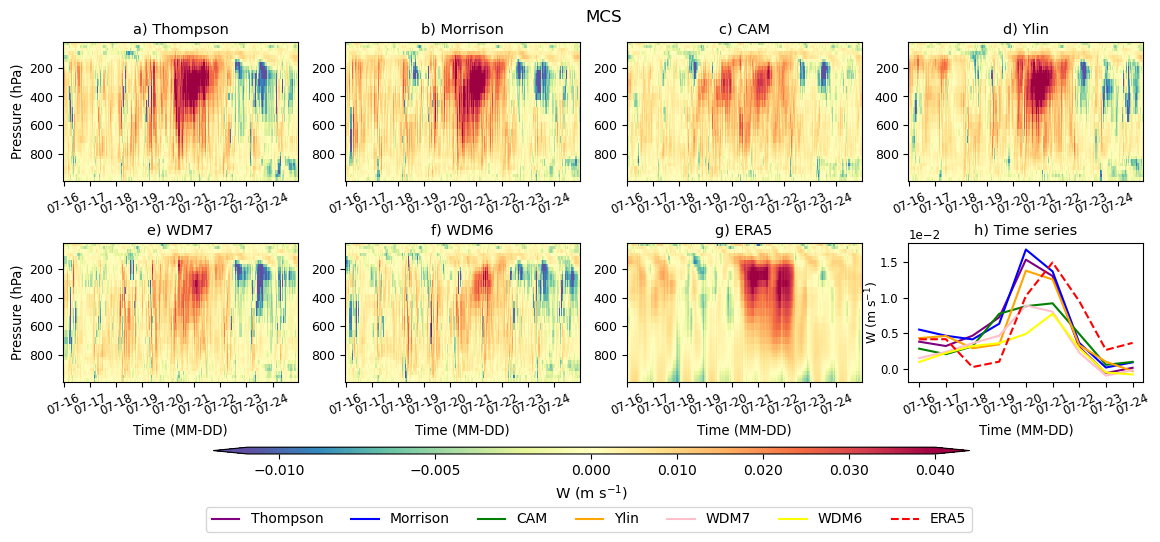

In [23]:
# Interpolated heatmaps for W 
# datasets
ds = [iimeanl_wtho.T, iimeanl_wmor.T, iimeanl_wcam.T, iimeanl_wylin.T, iimeanl_wwdm7.T, iimeanl_wwdm6.T, means_wERA]
titl=['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5']

# create figure
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
axs=axs.flatten()
fig.suptitle('MCS', y=1.03)

# time formatting
time = ['07-16', '07-17', '07-18', '07-19', '07-20', '07-21',  '07-22',  '07-23',  '07-24']
times=['2008-07-16', '2008-07-17', '2008-07-18', '2008-07-19', '2008-07-20', '2008-07-21', '2008-07-22', '2008-07-23', '2008-07-24']
times = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in times]
date_format = mdates.DateFormatter('%m-%d')

# Create a normalized colormap centered at 0
norm = mcolors.TwoSlopeNorm(vmin=-0.011, vmax=0.04, vcenter=0)

for i in range(0,7):
    axs[i].xaxis.set_major_formatter(date_format)
    axs[i].tick_params(axis='x', labelrotation = 25)
    axs[i].tick_params(axis='x', labelsize=8.5)  
    axs[i].tick_params(axis='y', labelsize=9)
    heatmap = axs[i].pcolormesh(means_wERA.time, means_wERA.level, ds[i], cmap='Spectral_r', norm=norm)
    axs[i].set_title(f'{(3*titl)[i]}', fontsize=10.5)
    axs[i].invert_yaxis()

axs[0].set_ylabel('Pressure (hPa)', fontsize=9.5)
axs[4].set_ylabel('Pressure (hPa)', fontsize=9.5)
axs[4].set_xlabel(r'Time (MM-DD)', fontsize=9.5)
axs[5].set_xlabel(r'Time (MM-DD)', fontsize=9.5)
axs[6].set_xlabel(r'Time (MM-DD)', fontsize=9.5)

# plot timeseries
axs[7].plot(time, wavgdaily[0], color='purple', label='Thompson')
axs[7].plot(time, wavgdaily[1], color='blue', label='Morrison')
axs[7].plot(time, wavgdaily[2], color='green', label='CAM')
axs[7].plot(time, wavgdaily[3], color='orange', label='Ylin')
axs[7].plot(time, wavgdaily[4], color='pink', label='WDM7')
axs[7].plot(time, wavgdaily[5], color='yellow', label='WDM6')
axs[7].plot(time, wavgdaily[6], color='r', linestyle='dashed' ,label='ERA5')
axs[7].tick_params(axis='x', rotation=25, labelsize=8.5)
axs[7].tick_params(axis='y', labelsize=8.5)
axs[7].set_title('h) Time series', fontsize=10.5)
axs[7].set_ylabel(r'W (m s$^{-1}$)', fontsize=9, labelpad=-0.5)
axs[7].set_xlabel(r'Time (MM-DD)', fontsize=9.5)
# format scale of y axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
axs[7].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
offset_text = axs[7].yaxis.get_offset_text()
offset_text.set_fontsize(8.5) 

# Adjust layout to prevent clipping of axis labels
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.45)
# Add colorbar
cbar_ax = fig.add_axes([0.175, -0.08, 0.63, 0.017])
cbar=plt.colorbar(heatmap, cax=cbar_ax, orientation='horizontal', ticks=[-0.01, -0.005, 0, 0.01, 0.02, 0.03, 0.04], extend='both')
axs[7].legend(loc='upper right', ncol=7, bbox_to_anchor=(0.3, -0.85))
cbar.set_label('W (m s$^{-1}$)', fontsize = 10.5)

# Save the plot as a hd file
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_paper_hd/w-mcs.png', dpi=400, bbox_inches='tight')